In [2]:
import os
import shutil
import pandas as pd
import numpy as np
from multiprocessing import Pool, cpu_count
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("paper", font_scale=2.0)
sns.set_style('whitegrid')

from functions import *

from pandarallel import pandarallel

pandarallel.initialize(progress_bar=False)

with SequenceFile("data/uniprot-9606.fasta", digital=True, alphabet=alphabet) as seq_file:
    sequences = list(seq_file)


uniprot = fasta_reader('data/uniprot-9606.fasta')

INFO: Pandarallel will run on 48 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
def newaa(seq, ins_rate, random=12345, ):
    aa = 'ACDEFGHIKLMNPQRSTVWY'
    rnd = np.random.default_rng(random+ins_rate)
    to_ins = rnd.choice(len(seq), ins_rate*len(seq)//100, replace=False)
    new_seq = []
    for i, v in enumerate(seq):
        if i in to_ins:
            # put a new AA at that place
            rand_aa = rnd.choice(list([i for i in aa if i != v]))
            new_seq.append(rand_aa)
        else:
            new_seq.append(v)

    return ''.join(new_seq)


def gen_reads_newaa(seq, aa_known, max_prob, newaa_rate, random,):
#     seq0 = dels(seq, del_rate, random)
    seq0 = seq
    seq1 = newaa(seq0, newaa_rate, random,)
    return generate_reads(seq1, aa_known, max_prob)

In [4]:
aa_knowns = ['ACDEFGHIKLMNPQRSTVWY']

prob_range = [0.8,]


all_ratenewaa = [0, 10, 20, 30, 40, 50, 60]



repeats = 1


random = 0

In [5]:
aa_knowns = ['ACDEFGHIKLMNPQRSTVWY']

prob_range = [0.8,]


all_ratenewaa = [0, 10, 20, 30, 40, 50, 60]

repeats = 1


random = 0

for a, b in enumerate(all_ratenewaa):
    newaa_rate = b

    for aa_known in aa_knowns:
        for rep in range(repeats):
#             random += ins_rate + del_rate + len(aa_knowns) + rep
            random = 12345
            for prob in prob_range:
#                 fname = f'{rep}_full_length_{aa_known}_max_prob_{prob}_ins_{ins_rate}_del_{del_rate}_1_ins.pkl.gz'
#                 if not os.path.isfile('results/scan_results/'+fname):
                temp_df = uniprot.copy()
                temp_df['temp'] = temp_df.values.tolist() 
                temp_df['posteriors'] =  temp_df.temp.parallel_apply(\
                                     lambda x: gen_reads_newaa(seq=x[1], aa_known=aa_known, max_prob=prob, \
                                                               newaa_rate=newaa_rate, random=random, ))


                temp_df['temp1'] = temp_df[['Accession', 'posteriors']].values.tolist() 
                temp_df['hmm'] = temp_df.temp1.parallel_apply(\
                         lambda x: hmm_build(x[1], x[0], \
                     f'{rep}_full_length_{x[0]}_{aa_known}_max_prob_{prob}_newaa_rate_{newaa_rate}'))


                hmms = np.array_split(temp_df.hmm, 10)
                hmms = [i.tolist() for i in hmms]

                results = []
                for i, v in enumerate(hmms):
                    results.append(score(v, sequences, background))
                #             print(f'\t\t\t\tdone: {i}', end='\r')
                fname = f'{rep}_full_length_{aa_known}_max_prob_{prob}_newaa_rate_{newaa_rate}.pkl.gz'

                res_df = pd.concat(results)
                res_df.to_pickle('results/scan_results/' + fname)
                del temp_df, res_df, hmms
                shutil.rmtree('temp/', ignore_errors=True)
                try:
                    os.makedirs('temp/')
                except FileExistsError:
                    pass

#### Plot

In [6]:
from glob import glob
results = glob('results/scan_results/*.pkl.gz')

In [7]:
from glob import glob
results = glob('results/scan_results/*.pkl.gz')
res = [i for i in results if 'newaa_rate_' in i]
# hmms = [i for i in results if 'entropy_results' in i]

all_ratenewaa = [0, 10, 20, 30, 40, 50, 60]

aa_knowns = ['ACDEFGHIKLMNPQRSTVWY']
prob_range = [0.8,]
repeats = 1



heatmap_df = pd.DataFrame(columns=['substitution rate (%)', 'known aa', \
                                'total queries', 'hits',  'identified', 'Type'])


idx = 0
for rep in range(repeats):
    for aa_known in aa_knowns:
        for v in all_ratenewaa:
            for prob in prob_range:
                newaa_rate = v
    #             print(idx, end='\r')

                fname = f'{rep}_full_length_{aa_known}_max_prob_{prob}_newaa_rate_{newaa_rate}.pkl.gz'

                try:

                    tmp0 = pd.read_pickle('results/scan_results/' + fname)
                    tmp0 = tmp0.reset_index(drop=True)

                    hmms = list(range(uniprot.shape[0]))

                    stats = gen_stats(hmms, tmp0)

                    heatmap_df.loc[idx] = [v, aa_known, stats['Total queries'], \
                                       stats['Hits'], stats['Identified'], 'Full length' ]
                    idx += 1
                    del tmp0
                except Exception as exp:
    #                 print(exp)
                    pass
heatmap_df['Accuracy'] = heatmap_df['identified']/heatmap_df['total queries']



In [8]:
heatmap_df

,substitution rate (%),known aa,total queries,hits,identified,Type,Accuracy
0,0,ACDEFGHIKLMNPQRSTVWY,20181,20179,19983,Full length,0.990189
1,10,ACDEFGHIKLMNPQRSTVWY,20181,20179,19998,Full length,0.990932
2,20,ACDEFGHIKLMNPQRSTVWY,20181,20177,19992,Full length,0.990635
3,30,ACDEFGHIKLMNPQRSTVWY,20181,20177,19995,Full length,0.990783
4,40,ACDEFGHIKLMNPQRSTVWY,20181,20168,19943,Full length,0.988207
5,50,ACDEFGHIKLMNPQRSTVWY,20181,20125,19812,Full length,0.981715
6,60,ACDEFGHIKLMNPQRSTVWY,20181,19726,19044,Full length,0.94366


/tmp/ipykernel_2129594/3726078271.py:18: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


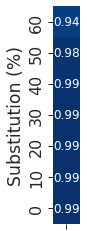

In [9]:
sns.set_context("paper", font_scale=1.8)
sns.set_style('ticks')

plot_df = pd.DataFrame(columns=all_ratenewaa)
plot_df.loc[0] = heatmap_df['Accuracy'].values

plt.figure(figsize=(0.5, 4))
ax = sns.heatmap(data=plot_df.T, cmap='Blues', 
                    annot=True, fmt=".2f",
                    vmin=0, vmax=1, annot_kws={"size":12}, 
#                  cbar_kws={"shrink": 0.5, "pad":1.1}
                cbar=None
                )
ax.set_ylabel('Substitution (%)')
# ax.set_yticklabels(' ')
ax.set_xticklabels('');
ax.invert_yaxis()
plt.tight_layout()

#### Results from insertion

In [10]:
full_length_error = pd.read_pickle('results/heatmap_df_full_length_1_ins_p_0.8.pkl.gz')

In [17]:
plot_df_ = full_length_error[(full_length_error['known aa'] == 'ACDEFGHIKLMNPQRSTVWY') & \
                 (full_length_error['deletions'] == 0)][['precision']]
plot_df1 = pd.DataFrame(columns=all_ratenewaa)
plot_df1.loc[0] = plot_df_['precision'].values
plot_df1

,0,10,20,30,40,50,60
0,0.990189,0.991477,0.991527,0.992865,0.993657,0.993905,0.984044


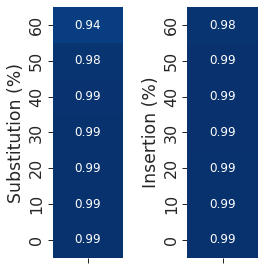

In [28]:
sns.set_context("paper", font_scale=1.8)
sns.set_style('ticks')

plot_df = pd.DataFrame(columns=all_ratenewaa)
plot_df.loc[0] = heatmap_df['Accuracy'].values

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(4, 4))

# substitution
sns.heatmap(data=plot_df.T, cmap='Blues', 
                    annot=True, fmt=".2f",
                    vmin=0, vmax=1, annot_kws={"size":12}, 
#                  cbar_kws={"shrink": 0.5, "pad":1.1}
                cbar=None, ax=ax[0]
                )
ax[0].set_ylabel('Substitution (%)')

ax[0].set_xticklabels('');
ax[0].invert_yaxis()

# insertions
sns.heatmap(data=plot_df1.T, cmap='Blues', 
                    annot=True, fmt=".2f",
                    vmin=0, vmax=1, annot_kws={"size":12}, 
#                  cbar_kws={"shrink": 0.5, "pad":1.1}
                cbar=None, ax=ax[1]
                )
ax[1].set_ylabel('Insertion (%)')

ax[1].set_xticklabels('');
ax[1].invert_yaxis()

plt.subplots_adjust(hspace=1)

plt.tight_layout()